In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pydotplus
from six import StringIO  
from IPython.display import Image
import xgboost as xgb

from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.metrics import accuracy_score,precision_score, recall_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd


from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder

from sklearn.compose import ColumnTransformer

# Import tools needed for visualization
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.tree import export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt

# Models & Processing
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

# Tuning of Model
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

# Imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

### Importing the Model

In [ ]:
df = pd.read_csv('https://github.com/tzekiattok/strokedata/blob/main/healthcare-dataset-stroke-data.csv?raw=true')

In [ ]:
df.info()
#let stroke the the label, (0,1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.drop('id', axis=1, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


ID is removed as there is no meaningful Data to Retrieve from the ID

### Fill in Missing Value

The decision tree regressor will analyze the age, gender and bmi of other observations and use that information to predict the value of the missing bmi based on the age and gender of the observation.

In [ ]:
DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=0))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


### Label Encode

Label Encoding - Categorical data with binary response

In [ ]:
##Label Encode Binary
residence_type = df['Residence_type'].unique()
ever_married = df['ever_married'].unique()
le = LabelEncoder()

le.fit(residence_type)
df['Residence_type'] = le.transform(df['Residence_type'])

le.fit(ever_married)
df['ever_married'] = le.transform(df['ever_married'])

### Defining Variable

*   y - target variable - stroke 

In [ ]:
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 
       'avg_glucose_level', 'bmi', 'smoking_status']]
y = df['stroke']

### OneHot Encode

One Hot Encode - Categorical data with more than two types of response

In [ ]:
#One Hot Encode everything
encoder = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['gender', 'work_type', 'smoking_status'])], remainder='passthrough')
X = np.array(encoder.fit_transform(X))

### Train Test Split

*   Use random state=424 to get a standardise results across the different machine learning models
*   Use test size = 0.2 (Commonly split 80-20 for train-test data)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=424)

### Scaling

   Standardise data for variables such as 'avg_glucose_level' that has a different scale from the other variables

In [ ]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### Outlier Removal

*   Remove outliers so that it will not affect the results when performing analysis on random forest

In [ ]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1, random_state=424)
yhat = iso.fit_predict(X_train_scaled)

In [ ]:
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train_scaled[mask], y_train[mask]

### Imbalance Oversamping

*   Apply Random Oversampling only to train data to see how well the model performs in real world using imbalance test data

In [ ]:
ros = RandomOverSampler() 

# fit predictor and target variable
X_train_ros, y_train_ros =  ros.fit_resample(X_train, y_train.ravel())

### PCA

*   To validate if PCA is meaningful in the analysis of model for this dataset
*   Apply PCA to all 19 columns (components) and find the appropriate number of columns that meets 95% cumulative variance ratio.


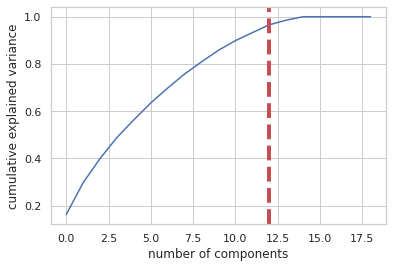

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.163215,0.163215
1,0.297837,0.134622
2,0.400235,0.102399
3,0.489304,0.089068
4,0.564055,0.074752
5,0.635440,0.071384
6,0.698503,0.063063
7,0.757759,0.059256
8,0.809220,0.051460
9,0.858180,0.048961


In [ ]:
pca_test = PCA(n_components=19)
pca_test.fit(X_train_ros)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=12, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(14))

In [ ]:
# View top variables
pca = PCA(n_components=12)
pca.fit(X_train_ros)

X_train_ros = pca.transform(X_train_ros)
X_test = pca.transform(X_test)

### Accuracy After PCA

* The model is evaluated with PCA to see how well the Model Perform without PCA First
* The Model is train and parameter tune with GridSearch CV
* Identify the accuracy, precision, recall, f1_score and ROC AUC score for the base model

#### Base Model

In [ ]:
dt = DecisionTreeClassifier(random_state=424)
dt.fit(X_train_ros, y_train_ros)

DecisionTreeClassifier(random_state=424)

[[928  41]
 [ 49   4]]
Accuracy: 0.9119373776908023 
 Precision: 0.08888888888888889 
 Recall: 0.07547169811320754 
 f1_score: 0.08163265306122448 

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       969
           1       0.09      0.08      0.08        53

    accuracy                           0.91      1022
   macro avg       0.52      0.52      0.52      1022
weighted avg       0.91      0.91      0.91      1022

ROC AUC score: 0.5165800183032497
Accuracy Score:  0.9119373776908023


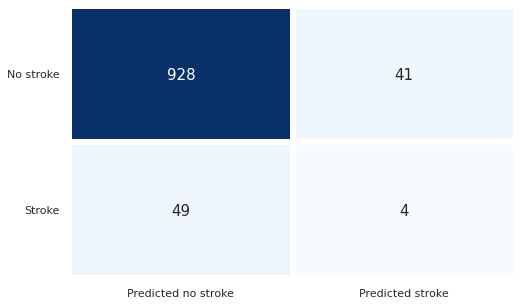

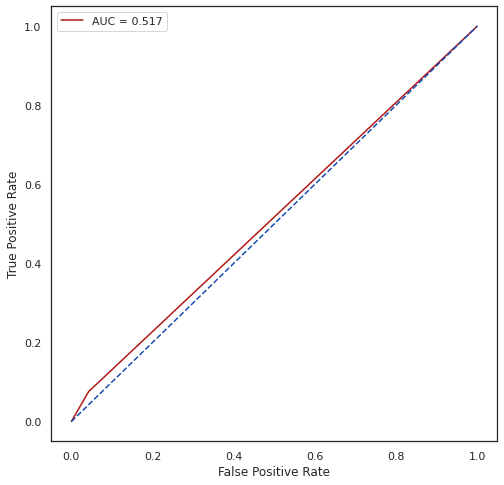

In [ ]:
y_pred = dt.predict(X_test)
y_prob = dt.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(cm)

accuracy = accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred) 
recall = metrics.recall_score(y_test, y_pred) 
f1_score = metrics.f1_score(y_test, y_pred) 
print('Accuracy:',
      accuracy,'\n Precision:',  precision,'\n Recall:',  recall,'\n f1_score:',  f1_score, '\n')


print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc AUC Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

#### Tuned Model

In [ ]:
params = [{
    'max_depth': [5,8],
    'max_features': [8, 10, 12],
    'criterion':['gini','entropy'],
    'random_state':[424]
}]

dt = DecisionTreeClassifier()

gs_dt = GridSearchCV(dt,
                      param_grid=params,
                      scoring='roc_auc',
                      cv=10)

In [ ]:
gs_dt.fit(X_train_ros, y_train_ros)
gs_dt.best_params_

{'criterion': 'gini', 'max_depth': 8, 'max_features': 10, 'random_state': 424}

[[736 233]
 [ 24  29]]
Accuracy: 0.7485322896281801 
 Precision: 0.11068702290076336 
 Recall: 0.5471698113207547 
 f1_score: 0.1841269841269841 

              precision    recall  f1-score   support

           0       0.97      0.76      0.85       969
           1       0.11      0.55      0.18        53

    accuracy                           0.75      1022
   macro avg       0.54      0.65      0.52      1022
weighted avg       0.92      0.75      0.82      1022

ROC AUC score: 0.6657807114901572
Accuracy Score:  0.7485322896281801


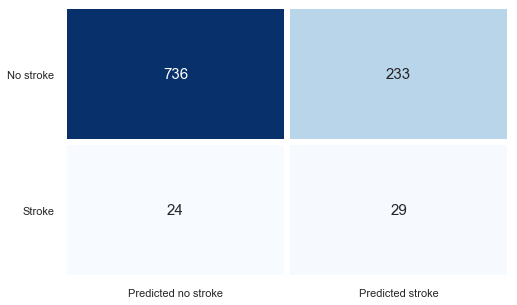

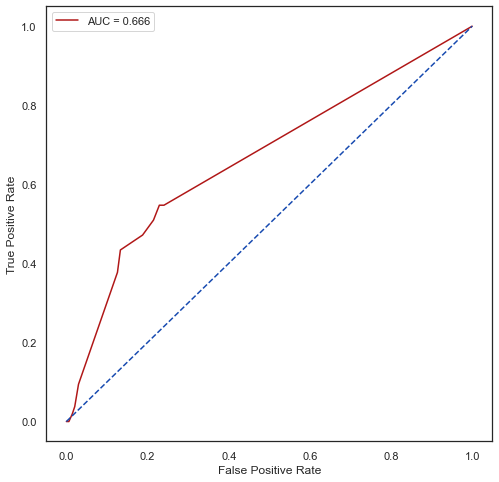

In [ ]:
y_pred = gs_dt.predict(X_test)
dt = DecisionTreeClassifier(criterion = 'gini', max_depth=8, max_features=10, random_state = 424)
dt.fit(X_train_ros, y_train_ros)
y_pred = dt.predict(X_test)
y_prob = dt.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(cm)

accuracy = accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred) 
recall = metrics.recall_score(y_test, y_pred) 
f1_score = metrics.f1_score(y_test, y_pred) 
print('Accuracy:',
      accuracy,'\n Precision:',  precision,'\n Recall:',  recall,'\n f1_score:',  f1_score, '\n')


print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc AUC Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()